# Preamble

In [1]:
import xarray as xr
import numpy as np
import holoviews as hv
from pathlib import Path
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
# %matplotlib widget

from holoviews import opts
import dask.array as da
from dask.distributed import Client, LocalCluster
import param
from holoviews import streams
from scipy.ndimage import label, find_objects
# Get working directory
import sys, os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import marineHeatWaves as mhw

# Import data

In [2]:
ds_lswt = xr.open_dataset('..\..\output\DINEOF_lake_dataset_with_clim.nc')
ds_lswt

<xarray.Dataset>
Dimensions:      (time: 5844, lat: 52, lon: 43)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2022-12-31
  * lat          (lat) float64 45.45 45.45 45.46 45.47 ... 45.85 45.86 45.87
  * lon          (lon) float64 10.51 10.52 10.53 10.54 ... 10.85 10.85 10.86
Data variables:
    lswt         (time, lat, lon) float32 ...
    clim         (time, lat, lon) float64 ...
    thresh       (time, lat, lon) float64 ...
    intensity    (time, lat, lon) float64 ...
    category     (time, lat, lon) float64 ...
    extrathresh  (time, lat, lon) float64 ...

# Methodology

In [3]:
da_intensity=ds_lswt.intensity
da_category=ds_lswt.category

In [4]:
# Specify the path to the NetCDF file
mask_path = '..\..\output\DINEOF_HWs_mask_per_cell.nc'

# Open the NetCDF file as an xarray dataset
mask_xr = xr.open_dataset(mask_path)
mask = mask_xr['__xarray_dataarray_variable__'].values

In [5]:
da_category_masked = da_category.where(mask_xr, drop=False)

## Modify the mask to keep only groups bigger than the threshold

In [8]:
threshold_area_percentage = 0.1  #### Set the minimum percentage of area to consider a group e.g 10%

# Initialize the new mask with False values
new_mask = np.zeros_like(mask, dtype=bool)

# Iterate over each day
for t in range(mask.shape[0]):
    # Find connected components for the current day
    labeled_array, num_features = label(mask[t])

    # Calculate the total non-NaN area for the day
    total_area = np.sum(~np.isnan(da_category[t]))

    # Initialize a list to store the areas of each group
    group_areas = []

    # Iterate over each labeled group
    for label_id in range(1, num_features + 1):  # Start from 1 since 0 represents background
        # Extract the region corresponding to the label
        group_region = labeled_array == label_id

        # Calculate the area of the group
        group_area = np.sum(group_region)

        # Append the area to the list
        group_areas.append(group_area)

    # Calculate the threshold area for the current day (10% of total non-NaN area)
    threshold_area = total_area * threshold_area_percentage

    # Iterate over each labeled group again and update the mask
    for label_id, group_area in enumerate(group_areas, 1):
        if group_area >= threshold_area:
            # Retain the group by setting the corresponding values in the new mask to True
            new_mask[t][labeled_array == label_id] = True

# Now, 'new_mask' contains True where the condition is satisfied for each day


In [9]:
new_mask_xr = xr.DataArray(new_mask, dims=da_category.dims, coords=da_category.coords)

# Now you can use .where() with the DataArray
new_da_category_masked = da_category.where(new_mask_xr, drop=True)
new_da_intensity_masked = da_intensity.where(new_mask_xr, drop=False)
# Save the dataset to a NetCDF file
new_mask_xr.to_netcdf('..\..\output\DINEOF_HWs_groups_mask.nc')

## Create a dataframe that contains all the HWs

In [10]:
# Initialize lists to store event details
event_starts = []
event_ends = []
event_durations = []

# Initialize variables to keep track of the current event
current_event_start = None
current_event_duration = 0

# Iterate over each day in the mask
for t in range(new_mask.shape[0]):
    # Check if there is any True value in the mask for the current day
    if np.any(new_mask[t]):
        # If it's the start of a new event
        if current_event_start is None:
            current_event_start = da_category.coords['time'].values[t]
            current_event_duration = 1
        else:
            current_event_duration += 1
    else:
        # If there is no True value in the mask for the current day
        if current_event_start is not None:
            # End of the current event
            event_starts.append(current_event_start)
            event_ends.append(da_category.coords['time'].values[t - 1])
            event_durations.append(current_event_duration)
            # Reset the current event
            current_event_start = None
            current_event_duration = 0

# Create a DataFrame from the event details
heatwaves_df = pd.DataFrame({
    'date_start': pd.to_datetime(event_starts),
    'date_end': pd.to_datetime(event_ends),
    'duration': event_durations
})

# Print the DataFrame
print(heatwaves_df)


    date_start   date_end  duration
0   2007-01-01 2007-02-11        42
1   2007-02-16 2007-03-11        24
2   2007-03-14 2007-03-17         4
3   2007-04-10 2007-05-04        25
4   2007-05-07 2007-05-15         9
..         ...        ...       ...
122 2022-08-14 2022-08-17         4
123 2022-08-23 2022-09-15        24
124 2022-10-10 2022-11-03        25
125 2022-11-12 2022-11-25        14
126 2022-12-05 2022-12-09         5

[127 rows x 3 columns]


### Eliminate the events with duration <5 and Merge the ones separated by max 2 days

In [11]:
# Filter out events with duration less than 5 days
heatwaves_df = heatwaves_df[heatwaves_df['duration'] >= 5].reset_index(drop=True)
heatwaves_df

date_start   date_end  duration
0   2007-01-01 2007-02-11        42
1   2007-02-16 2007-03-11        24
2   2007-04-10 2007-05-04        25
3   2007-05-07 2007-05-15         9
4   2007-06-02 2007-06-28        27
..         ...        ...       ...
101 2022-08-03 2022-08-12        10
102 2022-08-23 2022-09-15        24
103 2022-10-10 2022-11-03        25
104 2022-11-12 2022-11-25        14
105 2022-12-05 2022-12-09         5

[106 rows x 3 columns]

In [12]:
# Merge consecutive events where the difference between date_end of one event and date_start of the next event is <= 2 days
merged_events = []
i = 0
while i < len(heatwaves_df) - 1:
    current_event = heatwaves_df.iloc[i]
    next_event = heatwaves_df.iloc[i + 1]
    if (next_event['date_start'] - current_event['date_end']).days <=2:
        merged_events.append({
            'date_start': current_event['date_start'],
            'date_end': next_event['date_end'],
            'duration': (next_event['date_end'] - current_event['date_start']).days + 1
        })
        i += 2
    else:
        merged_events.append({
            'date_start': current_event['date_start'],
            'date_end': current_event['date_end'],
            'duration': current_event['duration']
        })
        i += 1

# Add the last event if it wasn't merged
if i == len(heatwaves_df) - 1:
    last_event = heatwaves_df.iloc[-1]
    merged_events.append({
        'date_start': last_event['date_start'],
        'date_end': last_event['date_end'],
        'duration': last_event['duration']
    })

# Convert merged events into a DataFrame
filtered_heatwaves_df = pd.DataFrame(merged_events).reset_index(drop=True)

# Print the filtered DataFrame
print(filtered_heatwaves_df)

    date_start   date_end  duration
0   2007-01-01 2007-02-11        42
1   2007-02-16 2007-03-11        24
2   2007-04-10 2007-05-04        25
3   2007-05-07 2007-05-15         9
4   2007-06-02 2007-06-28        27
..         ...        ...       ...
100 2022-08-03 2022-08-12        10
101 2022-08-23 2022-09-15        24
102 2022-10-10 2022-11-03        25
103 2022-11-12 2022-11-25        14
104 2022-12-05 2022-12-09         5

[105 rows x 3 columns]


### Add Min, Max, Mean Intensity 

In [13]:
# Function to calculate intensity statistics
def calculate_intensity_stats(row):
    # Convert date strings to datetime objects
    date_start = pd.to_datetime(row['date_start'])
    date_end = pd.to_datetime(row['date_end'])
    
    # Select intensity data for the corresponding time interval
    intensity_subset = new_da_intensity_masked.sel(time=slice(date_start, date_end))
    
    # Calculate statistics
    max_intensity = intensity_subset.max().values
    min_intensity = intensity_subset.min().values
    mean_intensity = intensity_subset.mean().values
    
    return pd.Series({
        'max_intensity': max_intensity,
        #'min_intensity': min_intensity,
        'mean_intensity': mean_intensity
    })

# Apply the function to each row in the DataFrame
intensity_stats_df = filtered_heatwaves_df.apply(calculate_intensity_stats, axis=1)

# Merge the calculated statistics with the original DataFrame
filtered_heatwaves_df = pd.concat([filtered_heatwaves_df, intensity_stats_df], axis=1)

# # Display the updated DataFrame
# print(filtered_heatwaves_df)

### Add Category

In [14]:
# Define mapping from numerical values to words
category_mapping = {
    1: 'moderate',
    2: 'strong',
    3: 'severe',
    4: 'extreme'
}

# Function to calculate category statistics
def calculate_category_stats(row):
    # Convert date strings to datetime objects
    date_start = pd.to_datetime(row['date_start'])
    date_end = pd.to_datetime(row['date_end'])
    
    # Select category data for the corresponding time interval
    category_subset = new_da_category_masked.sel(time=slice(date_start, date_end))
    
    # Calculate the maximum category value
    max_category = category_subset.max().item()
    
    # Map numerical category value to corresponding word
    max_category_word = category_mapping.get(max_category, 'Unknown')
    
    return max_category_word

# Apply the function to each row in the DataFrame
filtered_heatwaves_df['category'] = filtered_heatwaves_df.apply(calculate_category_stats, axis=1)

# # Display the updated DataFrame
# print(filtered_heatwaves_df)

### Add Min, Max, Mean % of area Covered by Heatwaves

In [15]:
# Function to calculate percentage of area covered for each day
def calculate_area_coverage(date):
    # Select intensity data for the corresponding day
    intensity_subset = da_intensity.sel(time=date)
    masked_subset = new_da_intensity_masked.sel(time=date)
    
    # Count non-NaN values
    total_points = np.count_nonzero(~np.isnan(intensity_subset))
    masked_points = np.count_nonzero(~np.isnan(masked_subset))
    
    # Calculate percentage of area covered
    if total_points > 0:
        coverage_percentage = (masked_points / total_points) * 100
    else:
        coverage_percentage = np.nan
    
    return coverage_percentage

# Function to calculate area coverage statistics
def calculate_coverage_stats(row):
    # Convert date strings to datetime objects
    date_start = pd.to_datetime(row['date_start'])
    date_end = pd.to_datetime(row['date_end'])
    
    # Generate date range for the time interval
    date_range = pd.date_range(date_start, date_end)
    
    # Calculate coverage percentage for each day
    coverage_percentages = [calculate_area_coverage(date) for date in date_range]
    
    # Calculate statistics
    max_coverage = np.nanmax(coverage_percentages)
    min_coverage = np.nanmin(coverage_percentages)
    mean_coverage = np.nanmean(coverage_percentages)
    
    return pd.Series({
        'max_%_coverage': max_coverage,
        'min_%_coverage': min_coverage,
        'mean_%_coverage': mean_coverage
    })

# Apply the function to each row in the DataFrame
coverage_stats_df = filtered_heatwaves_df.apply(calculate_coverage_stats, axis=1)

# Merge the calculated statistics with the original DataFrame
filtered_heatwaves_df = pd.concat([filtered_heatwaves_df, coverage_stats_df], axis=1)

# Display the updated DataFrame
print(filtered_heatwaves_df)

    date_start   date_end  duration       max_intensity      mean_intensity  \
0   2007-01-01 2007-02-11        42   2.276405105177842   0.888435669337441   
1   2007-02-16 2007-03-11        24    2.96934272621219  1.1775071401521122   
2   2007-04-10 2007-05-04        25   6.231727750499228   2.858835954218165   
3   2007-05-07 2007-05-15         9   6.441304668457446  2.3848943552399957   
4   2007-06-02 2007-06-28        27   6.043792760332291   2.168443577681261   
..         ...        ...       ...                 ...                 ...   
100 2022-08-03 2022-08-12        10  2.4365895470776877  1.2645649698161356   
101 2022-08-23 2022-09-15        24   3.820633409865067  1.4635795627169905   
102 2022-10-10 2022-11-03        25   3.782319586196536    1.43673079920456   
103 2022-11-12 2022-11-25        14  2.4606700177196537  1.3811218630448967   
104 2022-12-05 2022-12-09         5   1.491164662039722  1.0707722525880488   

    category  max_%_coverage  min_%_coverage  mean_

In [16]:
# Sum all durations
new_total_duration = filtered_heatwaves_df['duration'].sum()

# Print total duration
print(f"New methodology Total Duration of All Heatwaves: {new_total_duration}/{len(ds_lswt.time)} total days")


New methodology Total Duration of All Heatwaves: 1500/5844 total days


# Create HWs dataset

In [17]:
ds_lswt_masked = ds_lswt.where(new_mask_xr, drop=False)
ds_lswt_masked

<xarray.Dataset>
Dimensions:      (time: 5844, lat: 52, lon: 43)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2022-12-31
  * lat          (lat) float64 45.45 45.45 45.46 45.47 ... 45.85 45.86 45.87
  * lon          (lon) float64 10.51 10.52 10.53 10.54 ... 10.85 10.85 10.86
Data variables:
    lswt         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    clim         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    thresh       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    intensity    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    category     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    extrathresh  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [18]:
# Keep only periods identified as HW
# List to store datasets corresponding to each date range
sliced_datasets = []
for _, row in filtered_heatwaves_df.iterrows():
    date_start = row['date_start']
    date_end = row['date_end']
    
    # Slice the dataset for the given date range
    sliced = ds_lswt_masked.sel(time=slice(date_start, date_end))
    sliced_datasets.append(sliced)

# Concatenate all sliced datasets along the time dimension
heatwaves_ds = xr.concat(sliced_datasets, dim='time')
heatwaves_ds

<xarray.Dataset>
Dimensions:      (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2022-12-09
  * lat          (lat) float64 45.45 45.45 45.46 45.47 ... 45.85 45.86 45.87
  * lon          (lon) float64 10.51 10.52 10.53 10.54 ... 10.85 10.85 10.86
Data variables:
    lswt         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    clim         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    thresh       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    intensity    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    category     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    extrathresh  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [19]:
# HWs % area coverage 

# Step 1: Create a mask where points are not in category 0 and are not NaN
not_category_0 = (heatwaves_ds['category'] != 0) & (~heatwaves_ds['category'].isnull())

# Step 2: Count the number of non-zero category points and total points for each day
# The sum of the mask will give the count of non-zero category points
non_zero_count = not_category_0.groupby('time').sum(dim=['lat', 'lon'])

# Calculate the total count of points (excluding NaNs) for each day
total_count = xr.where(heatwaves_ds['category'].notnull().any(dim=['lat', 'lon']), 
                       heatwaves_ds['category'].notnull().groupby('time').sum(dim=['lat', 'lon']), 
                       float('nan'))

# Step 3: Calculate the percentage of points not in category 0 for each day
# Ensure to handle the division when both non_zero_count and total_count are not NaN
percentage_not_category_0 = xr.where((non_zero_count.notnull()) & (total_count.notnull()), 
                                     (non_zero_count / total_count) * 100, 
                                     float('nan'))

# Step 4: Add this percentage as a new variable to the dataset
heatwaves_ds['hws_area_percentage'] = percentage_not_category_0

# Display the updated dataset
heatwaves_ds

<xarray.Dataset>
Dimensions:              (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time                 (time) datetime64[ns] 2007-01-01 ... 2022-12-09
  * lat                  (lat) float64 45.45 45.45 45.46 ... 45.85 45.86 45.87
  * lon                  (lon) float64 10.51 10.52 10.53 ... 10.85 10.85 10.86
Data variables:
    lswt                 (time, lat, lon) float32 nan nan nan ... nan nan nan
    clim                 (time, lat, lon) float64 nan nan nan ... nan nan nan
    thresh               (time, lat, lon) float64 nan nan nan ... nan nan nan
    intensity            (time, lat, lon) float64 nan nan nan ... nan nan nan
    category             (time, lat, lon) float64 nan nan nan ... nan nan nan
    extrathresh          (time, lat, lon) float64 nan nan nan ... nan nan nan
    hws_area_percentage  (time) float64 31.1 32.32 100.0 ... 100.0 100.0 100.0

In [20]:
# Categories % area coverage 

# Calculate the mask for each category
category_1_mask = heatwaves_ds['category'] == 1
category_2_mask = heatwaves_ds['category'] == 2
category_3_mask = heatwaves_ds['category'] == 3
category_4_mask = heatwaves_ds['category'] == 4

# Calculate the count of points in each category for each day
category_1_count = category_1_mask.groupby('time').sum(dim=['lat', 'lon'])
category_2_count = category_2_mask.groupby('time').sum(dim=['lat', 'lon'])
category_3_count = category_3_mask.groupby('time').sum(dim=['lat', 'lon'])
category_4_count = category_4_mask.groupby('time').sum(dim=['lat', 'lon'])

# Calculate the total count of points (excluding NaNs) for each day
total_count = xr.where(heatwaves_ds['category'].notnull().any(dim=['lat', 'lon']), 
                       heatwaves_ds['category'].notnull().groupby('time').sum(dim=['lat', 'lon']), 
                       float('nan'))

# Calculate the percentage of area covered by each category for each day
moderate_hws_area_percentage = xr.where((category_1_count.notnull()) & (total_count.notnull()), 
                                         (category_1_count / total_count) * 100, 
                                         float('nan'))
strong_hws_area_percentage = xr.where((category_2_count.notnull()) & (total_count.notnull()), 
                                      (category_2_count / total_count) * 100, 
                                      float('nan'))
severe_hws_area_percentage = xr.where((category_3_count.notnull()) & (total_count.notnull()), 
                                      (category_3_count / total_count) * 100, 
                                      float('nan'))
extreme_hws_area_percentage = xr.where((category_4_count.notnull()) & (total_count.notnull()), 
                                       (category_4_count / total_count) * 100, 
                                       float('nan'))

# Add these percentages as new variables to the dataset
heatwaves_ds['moderate_hws_area_percentage'] = moderate_hws_area_percentage
heatwaves_ds['strong_hws_area_percentage'] = strong_hws_area_percentage
heatwaves_ds['severe_hws_area_percentage'] = severe_hws_area_percentage
heatwaves_ds['extreme_hws_area_percentage'] = extreme_hws_area_percentage

# Display the updated dataset
heatwaves_ds

<xarray.Dataset>
Dimensions:                       (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time                          (time) datetime64[ns] 2007-01-01 ... 2022-1...
  * lat                           (lat) float64 45.45 45.45 ... 45.86 45.87
  * lon                           (lon) float64 10.51 10.52 ... 10.85 10.86
Data variables:
    lswt                          (time, lat, lon) float32 nan nan ... nan nan
    clim                          (time, lat, lon) float64 nan nan ... nan nan
    thresh                        (time, lat, lon) float64 nan nan ... nan nan
    intensity                     (time, lat, lon) float64 nan nan ... nan nan
    category                      (time, lat, lon) float64 nan nan ... nan nan
    extrathresh                   (time, lat, lon) float64 nan nan ... nan nan
    hws_area_percentage           (time) float64 31.1 32.32 ... 100.0 100.0
    moderate_hws_area_percentage  (time) float64 31.1 32.32 ... 100.0 100.0
    strong_hws_area_percentage    (time) float64 0.0 0.0 25.61 ... 0.0 0.0 0.0
    severe_hws_area_percentage    (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    extreme_hws_area_percentage   (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [21]:
# Max, min, mean intensity

# Step 1: Calculate daily minimum, maximum, and mean intensity
daily_min_intensity = heatwaves_ds['intensity'].groupby('time').min(dim=['lat', 'lon'])
daily_max_intensity = heatwaves_ds['intensity'].groupby('time').max(dim=['lat', 'lon'])
daily_mean_intensity = heatwaves_ds['intensity'].groupby('time').mean(dim=['lat', 'lon'])

# Add these as new variables to the dataset
heatwaves_ds['min_intensity'] = daily_min_intensity
heatwaves_ds['max_intensity'] = daily_max_intensity
heatwaves_ds['mean_intensity'] = daily_mean_intensity

heatwaves_ds

<xarray.Dataset>
Dimensions:                       (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time                          (time) datetime64[ns] 2007-01-01 ... 2022-1...
  * lat                           (lat) float64 45.45 45.45 ... 45.86 45.87
  * lon                           (lon) float64 10.51 10.52 ... 10.85 10.86
Data variables: (12/14)
    lswt                          (time, lat, lon) float32 nan nan ... nan nan
    clim                          (time, lat, lon) float64 nan nan ... nan nan
    thresh                        (time, lat, lon) float64 nan nan ... nan nan
    intensity                     (time, lat, lon) float64 nan nan ... nan nan
    category                      (time, lat, lon) float64 nan nan ... nan nan
    extrathresh                   (time, lat, lon) float64 nan nan ... nan nan
    ...                            ...
    strong_hws_area_percentage    (time) float64 0.0 0.0 25.61 ... 0.0 0.0 0.0
    severe_hws_area_percentage    (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    extreme_hws_area_percentage   (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    min_intensity                 (time) float64 -0.5719 -1.021 ... 0.8528
    max_intensity                 (time) float64 0.9527 1.104 ... 1.349 1.204
    mean_intensity                (time) float64 0.1443 0.0302 ... 1.074 1.019

In [22]:
# Calculate Cog position

# Get the data arrays
extrathresh = heatwaves_ds['extrathresh']
latitudes = heatwaves_ds['lat'].values
longitudes = heatwaves_ds['lon'].values

# Initialize arrays to store the COG coordinates
cog_lat = np.zeros(len(heatwaves_ds['time']))
cog_lon = np.zeros(len(heatwaves_ds['time']))

# Calculate COG for each day
for t in range(len(heatwaves_ds['time'])):
    daily_data = extrathresh.isel(time=t)
    
    # Mask for positive values
    positive_mask = daily_data > 0
    
    # Apply the mask to latitudes and longitudes
    positive_extrathresh = daily_data.where(positive_mask, 0)
    
    # Calculate weighted latitudes and longitudes
    total_weight = positive_extrathresh.sum().item()
    if total_weight > 0:
        cog_lat[t] = (positive_extrathresh * latitudes[:, None]).sum() / total_weight
        cog_lon[t] = (positive_extrathresh * longitudes[None, :]).sum() / total_weight
    else:
        cog_lat[t] = np.nan
        cog_lon[t] = np.nan

# Create new data arrays for COG lat and lon
cog_lat_da = xr.DataArray(cog_lat, coords=[heatwaves_ds['time']], dims=['time'], name='cog_lat')
cog_lon_da = xr.DataArray(cog_lon, coords=[heatwaves_ds['time']], dims=['time'], name='cog_lon')

# Add these data arrays to the dataset
heatwaves_ds = heatwaves_ds.assign(cog_lat=cog_lat_da, cog_lon=cog_lon_da)

heatwaves_ds

<xarray.Dataset>
Dimensions:                       (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time                          (time) datetime64[ns] 2007-01-01 ... 2022-1...
  * lat                           (lat) float64 45.45 45.45 ... 45.86 45.87
  * lon                           (lon) float64 10.51 10.52 ... 10.85 10.86
Data variables: (12/16)
    lswt                          (time, lat, lon) float32 nan nan ... nan nan
    clim                          (time, lat, lon) float64 nan nan ... nan nan
    thresh                        (time, lat, lon) float64 nan nan ... nan nan
    intensity                     (time, lat, lon) float64 nan nan ... nan nan
    category                      (time, lat, lon) float64 nan nan ... nan nan
    extrathresh                   (time, lat, lon) float64 nan nan ... nan nan
    ...                            ...
    extreme_hws_area_percentage   (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    min_intensity                 (time) float64 -0.5719 -1.021 ... 0.8528
    max_intensity                 (time) float64 0.9527 1.104 ... 1.349 1.204
    mean_intensity                (time) float64 0.1443 0.0302 ... 1.074 1.019
    cog_lat                       (time) float64 45.52 45.52 ... 45.54 45.52
    cog_lon                       (time) float64 10.6 10.6 10.66 ... 10.68 10.69

In [23]:
# Calculate displacement
# Extract time, cog_lat, and cog_lon
time = heatwaves_ds['time'].values
cog_lat = heatwaves_ds['cog_lat'].values
cog_lon = heatwaves_ds['cog_lon'].values

# Initialize arrays to store displacements
x_displacement = np.full(len(time), np.nan)
y_displacement = np.full(len(time), np.nan)
displacement_module = np.full(len(time), np.nan)

# Calculate displacements only for consecutive days
for t in range(1, len(time)):
    if (time[t] - time[t-1]) == np.timedelta64(1, 'D'):  # Check for consecutive days
        x_displacement[t] = cog_lon[t] - cog_lon[t-1]
        y_displacement[t] = cog_lat[t] - cog_lat[t-1]
        displacement_module[t] = np.sqrt(x_displacement[t]**2 + y_displacement[t]**2)

# Create new data arrays for displacements
x_displacement_da = xr.DataArray(x_displacement, coords=[heatwaves_ds['time']], dims=['time'], name='x_displacement')
y_displacement_da = xr.DataArray(y_displacement, coords=[heatwaves_ds['time']], dims=['time'], name='y_displacement')
displacement_module_da = xr.DataArray(displacement_module, coords=[heatwaves_ds['time']], dims=['time'], name='displacement_module')

# Add these data arrays to the dataset
heatwaves_ds = heatwaves_ds.assign(x_displacement=x_displacement_da,
                                   y_displacement=y_displacement_da,
                                   displacement_module=displacement_module_da)


heatwaves_ds

<xarray.Dataset>
Dimensions:                       (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time                          (time) datetime64[ns] 2007-01-01 ... 2022-1...
  * lat                           (lat) float64 45.45 45.45 ... 45.86 45.87
  * lon                           (lon) float64 10.51 10.52 ... 10.85 10.86
Data variables: (12/19)
    lswt                          (time, lat, lon) float32 nan nan ... nan nan
    clim                          (time, lat, lon) float64 nan nan ... nan nan
    thresh                        (time, lat, lon) float64 nan nan ... nan nan
    intensity                     (time, lat, lon) float64 nan nan ... nan nan
    category                      (time, lat, lon) float64 nan nan ... nan nan
    extrathresh                   (time, lat, lon) float64 nan nan ... nan nan
    ...                            ...
    mean_intensity                (time) float64 0.1443 0.0302 ... 1.074 1.019
    cog_lat                       (time) float64 45.52 45.52 ... 45.54 45.52
    cog_lon                       (time) float64 10.6 10.6 10.66 ... 10.68 10.69
    x_displacement                (time) float64 nan 0.002512 ... 0.006885
    y_displacement                (time) float64 nan 0.005391 ... -0.0201
    displacement_module           (time) float64 nan 0.005947 ... 0.02125

In [24]:
# Number of days with non-NaN values
cell_total_hws_days = heatwaves_ds['intensity'].notnull().sum(dim='time')
cell_total_hws_days = cell_total_hws_days.where(cell_total_hws_days > 0, np.nan)
# Mean intensity
cell_mean_intensity = heatwaves_ds['intensity'].mean(dim='time', skipna=True)

# Maximum intensity
cell_max_intensity = heatwaves_ds['intensity'].max(dim='time', skipna=True)

# Cumulative intensity
cell_cumulative_intensity = heatwaves_ds['intensity'].sum(dim='time', skipna=True)
cell_cumulative_intensity = cell_cumulative_intensity.where(cell_cumulative_intensity > 0, np.nan)

# Create new data arrays
cell_total_hws_days_da = xr.DataArray(cell_total_hws_days, coords=[heatwaves_ds['lat'], heatwaves_ds['lon']], dims=['lat', 'lon'], name='cell_total_hws_days')
cell_mean_intensity_da = xr.DataArray(cell_mean_intensity, coords=[heatwaves_ds['lat'], heatwaves_ds['lon']], dims=['lat', 'lon'], name='cell_mean_intensity')
cell_max_intensity_da = xr.DataArray(cell_max_intensity, coords=[heatwaves_ds['lat'], heatwaves_ds['lon']], dims=['lat', 'lon'], name='cell_max_intensity')
cell_cumulative_intensity_da = xr.DataArray(cell_cumulative_intensity, coords=[heatwaves_ds['lat'], heatwaves_ds['lon']], dims=['lat', 'lon'], name='cell_cumulative_intensity')

# Add these data arrays to the dataset
heatwaves_ds = heatwaves_ds.assign(cell_total_hws_days=cell_total_hws_days_da,
                                   cell_mean_intensity=cell_mean_intensity_da,
                                   cell_max_intensity=cell_max_intensity_da,
                                   cell_cumulative_intensity=cell_cumulative_intensity_da)

heatwaves_ds

<xarray.Dataset>
Dimensions:                       (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time                          (time) datetime64[ns] 2007-01-01 ... 2022-1...
  * lat                           (lat) float64 45.45 45.45 ... 45.86 45.87
  * lon                           (lon) float64 10.51 10.52 ... 10.85 10.86
Data variables: (12/23)
    lswt                          (time, lat, lon) float32 nan nan ... nan nan
    clim                          (time, lat, lon) float64 nan nan ... nan nan
    thresh                        (time, lat, lon) float64 nan nan ... nan nan
    intensity                     (time, lat, lon) float64 nan nan ... nan nan
    category                      (time, lat, lon) float64 nan nan ... nan nan
    extrathresh                   (time, lat, lon) float64 nan nan ... nan nan
    ...                            ...
    y_displacement                (time) float64 nan 0.005391 ... -0.0201
    displacement_module           (time) float64 nan 0.005947 ... 0.02125
    cell_total_hws_days           (lat, lon) float64 nan nan ... 1.003e+03 nan
    cell_mean_intensity           (lat, lon) float64 nan nan nan ... 2.656 nan
    cell_max_intensity            (lat, lon) float64 nan nan nan ... 6.7 nan
    cell_cumulative_intensity     (lat, lon) float64 nan nan ... 2.664e+03 nan

In [25]:
# Function to determine the season for a given time
def assign_season(time):
    month_day = time.dt.month * 100 + time.dt.day
    return xr.where((321 <= month_day) & (month_day <= 620), 'Spring',
           xr.where((621 <= month_day) & (month_day <= 920), 'Summer',
           xr.where((921 <= month_day) & (month_day <= 1220), 'Autumn', 'Winter')))

# Add the season as a variable to the dataset
heatwaves_ds['season'] = assign_season(heatwaves_ds['time'])

In [26]:
heatwaves_ds

<xarray.Dataset>
Dimensions:                       (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time                          (time) datetime64[ns] 2007-01-01 ... 2022-1...
  * lat                           (lat) float64 45.45 45.45 ... 45.86 45.87
  * lon                           (lon) float64 10.51 10.52 ... 10.85 10.86
Data variables: (12/24)
    lswt                          (time, lat, lon) float32 nan nan ... nan nan
    clim                          (time, lat, lon) float64 nan nan ... nan nan
    thresh                        (time, lat, lon) float64 nan nan ... nan nan
    intensity                     (time, lat, lon) float64 nan nan ... nan nan
    category                      (time, lat, lon) float64 nan nan ... nan nan
    extrathresh                   (time, lat, lon) float64 nan nan ... nan nan
    ...                            ...
    displacement_module           (time) float64 nan 0.005947 ... 0.02125
    cell_total_hws_days           (lat, lon) float64 nan nan ... 1.003e+03 nan
    cell_mean_intensity           (lat, lon) float64 nan nan nan ... 2.656 nan
    cell_max_intensity            (lat, lon) float64 nan nan nan ... 6.7 nan
    cell_cumulative_intensity     (lat, lon) float64 nan nan ... 2.664e+03 nan
    season                        (time) <U6 'Winter' 'Winter' ... 'Autumn'

In [27]:
plot = heatwaves_ds.cell_cumulative_intensity.hvplot(
    geo=True,
    cmap='fire_r',
    xlabel='Longitude', ylabel='Latitude',
    clabel='Category (1:Moderate - 2:Strong - 3:Severe - 4:Extreme)',
    tiles='CartoLight',
    width=300#,
#    widget_type='scrubber', widget_location='bottom'
)
plot

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Image.I :Image   [lon,lat]   (cell_cumulative_intensity)

In [28]:
import geoviews as gv
# import cartopy.crs as ccrs
# Variables to plot
variables = ['cell_total_hws_days', 'cell_mean_intensity', 'cell_max_intensity', 'cell_cumulative_intensity']
titles = ['Total Heatwave Days', 'Mean Intensity', 'Maximum Intensity', 'Cumulative Intensity']
clabels=['Number of Days','Mean Intensity [°C]','Maximum Intensity [°C]','Cumulative Intensity [°C]']
# Create plots for each variable
plots = []
for var, title, clabel in zip(variables, titles, clabels):
    plot = heatwaves_ds[var].hvplot(
        'lon', 'lat', 
        geo=True, 
        title=title, 
        xlabel='Longitude', ylabel='Latitude',
        clabel=clabel,
        cmap='fire_r', 
        tiles='CartoLight',
        coastline=True, 
        colorbar=True, 
        width=500,
        height=600
    )
    plots.append(plot)

# Combine plots into a single layout
layout = gv.Layout(plots).opts(shared_axes=True).cols(2)

# Show the plot
layout

:Layout
   .Overlay.I   :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (cell_total_hws_days)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (cell_mean_intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (cell_max_intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IV  :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (cell_cumulative_intensity)
      .Coastline.I :Feature   [Longitude,Latitude]

In [29]:
# Save the Dataset
heatwaves_ds.to_netcdf('..\..\output\Garda_heatwaves_dataset.nc')

# To excel

In [30]:
# Write the first DataFrame to a new Excel file
filtered_heatwaves_df.to_excel('..\..\output\DINEOF HWs Alternative Methodology.xlsx', index=False)

# Plot

In [31]:
# Define the variables, titles, and color labels
variables = {
    'lswt_max': ('lswt', 'max', 'Max LSWT [°C]'),
    'clim_mean': ('clim', 'mean', 'Mean Climatology [°C]'),
    'intensity_mean': ('intensity', 'mean', 'Mean Intensity [°C]'),
    'intensity_max': ('intensity', 'max', 'Max Intensity [°C]')
}

# Seasons to consider
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

# Create an empty list to hold all the plots
plots = []

# Loop through each season and each variable to create plots
for season in seasons:
    for var_name, (var, func, clabel) in variables.items():
        # Aggregate the data by season and function (mean or max)
        season_data = getattr(heatwaves_ds[var].sel(time=heatwaves_ds['season'] == season), func)(dim='time', skipna=True)

        # Determine the min and max values for color scaling
        vmin = season_data.min().values
        vmax = season_data.max().values
        
        # Create the plot for this specific season and variable
        plot = season_data.hvplot(
            'lon', 'lat', 
            geo=True, 
            title=f'{season} - {var_name.replace("_", " ").title()}', 
            xlabel='Longitude', ylabel='Latitude',
            clabel=clabel,
            cmap='jet', 
            tiles='CartoLight',
            coastline=True, 
            colorbar=True, 
            width=400, 
            height=483,
            clim=(vmin, vmax)  # Set individual color scale for each plot
        )
        
        # Append the plot to the list
        plots.append(plot)

# Combine the plots into a 4x4 grid layout
layout = gv.Layout(plots).opts(shared_axes=False).cols(4)
hv.save(layout, 'seasons_maps.png', fmt='png')
# Display the layout
layout

:Layout
   .Overlay.I    :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (lswt)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II   :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (clim)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III  :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IV   :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.V    :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (lswt)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VI   :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (clim)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VII  :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VIII :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IX   :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (lswt)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.X    :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (clim)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.XI   :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.XII  :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.XIII :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (lswt)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.XIV  :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (clim)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.XV   :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (intensity)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.XVI  :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [lon,lat]   (intensity)
      .Coastline.I :Feature   [Longitude,Latitude]

C:\ProgramData\anaconda3\envs\satellite\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\satellite\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\satellite\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\satellite\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

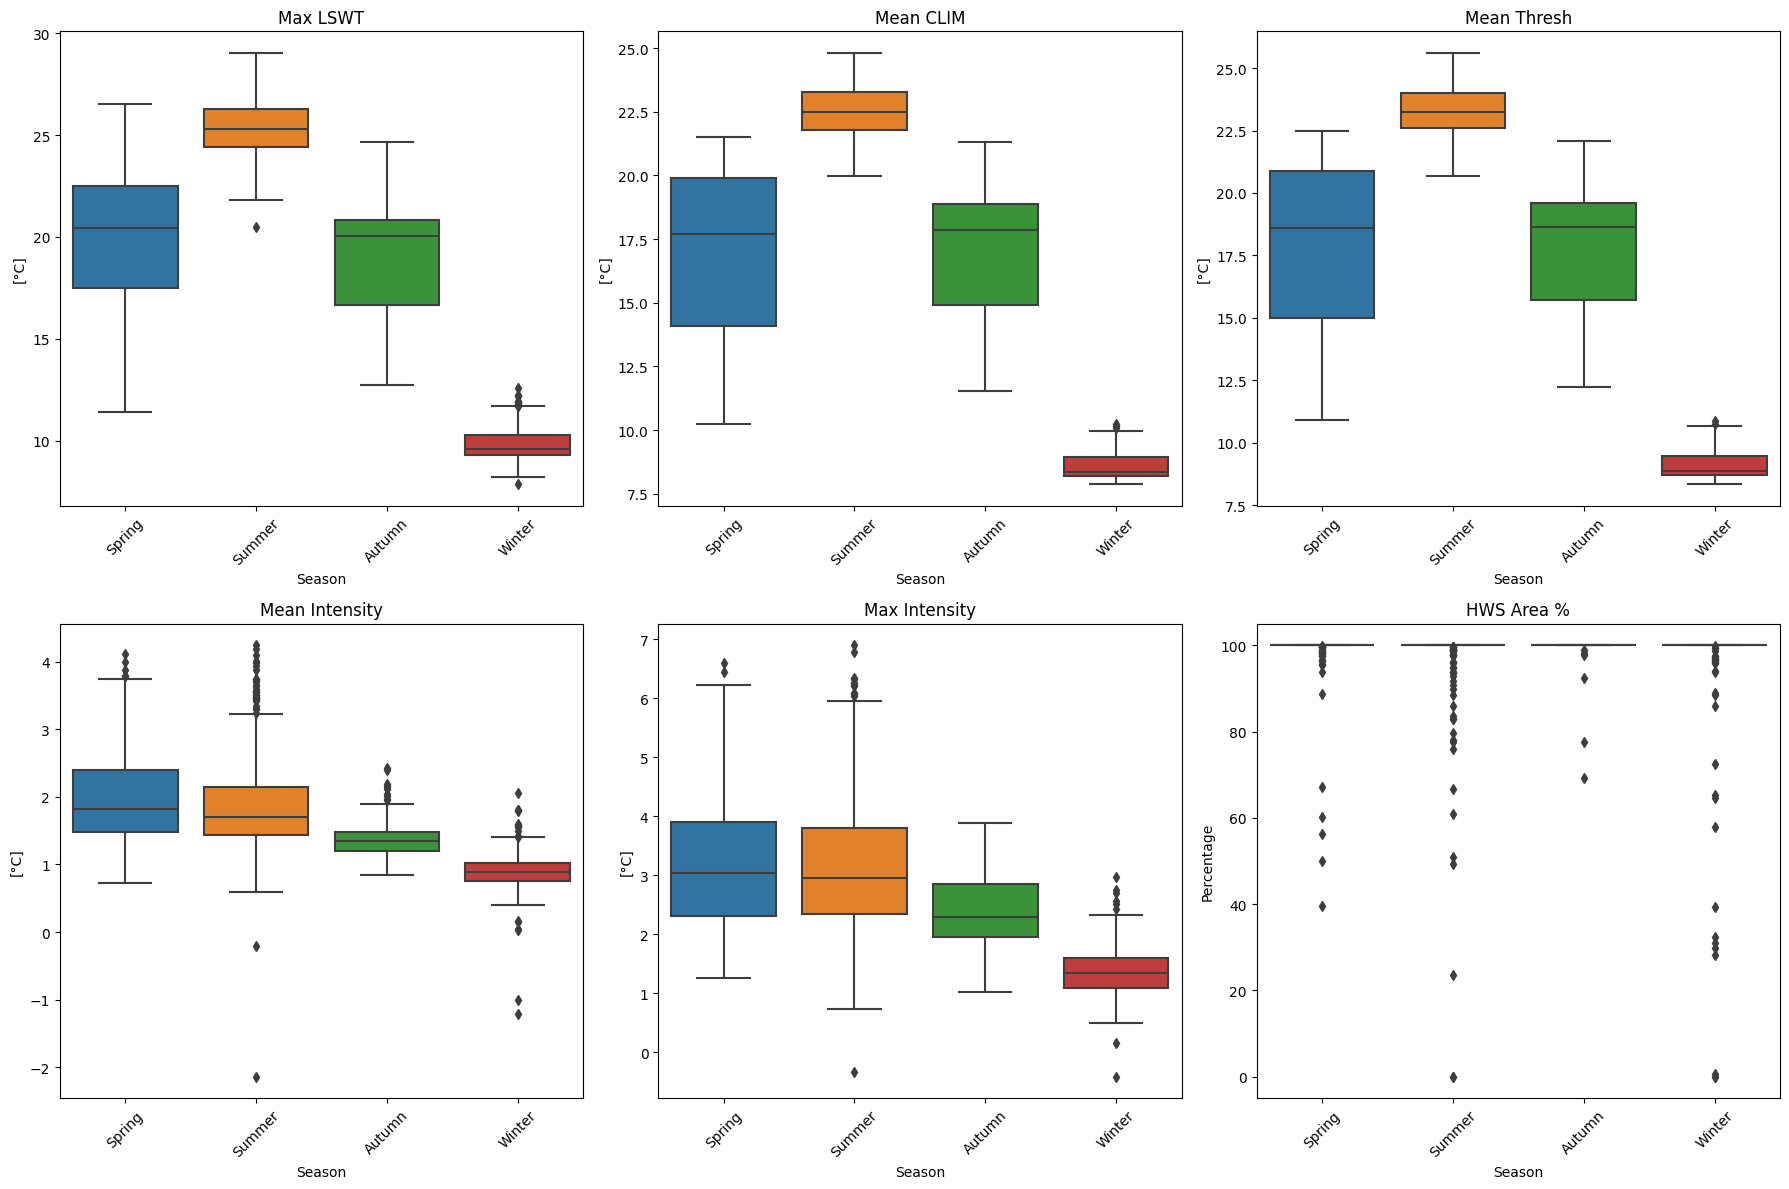

In [32]:

# Metrics to plot
metrics = {
    'lswt': 'max',       # max lswt
    'clim': 'mean',      # mean clim
    'thresh': 'mean',    # mean thresh
    'intensity_mean': 'mean',  # mean intensity
    'intensity_max': 'max',    # max intensity
    'hws_area_percentage': 'mean' # hws_area_percentage is already along time
}

y_labels = ['[°C]','[°C]','[°C]','[°C]','[°C]','Percentage']
# Prepare a DataFrame to hold the values for box plotting
data = []

for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    for var, agg in metrics.items():
        if 'intensity' in var:
            base_var = 'intensity'
        else:
            base_var = var
        
        if var == 'hws_area_percentage':
            # Use hws_area_percentage directly
            seasonal_data = heatwaves_ds[base_var].sel(time=heatwaves_ds['season'] == season).values
        else:
            # Aggregate according to the metric definition
            if agg == 'mean':
                seasonal_data = heatwaves_ds[base_var].sel(time=heatwaves_ds['season'] == season).mean(dim=['lat', 'lon'], skipna=True).values
            elif agg == 'max':
                seasonal_data = heatwaves_ds[base_var].sel(time=heatwaves_ds['season'] == season).max(dim=['lat', 'lon'], skipna=True).values
        
        # Flatten the values into a list and pair with the season and variable name
        for value in seasonal_data.flatten():
            data.append((season, var, value))

# Convert the data to a DataFrame
df = pd.DataFrame(data, columns=['Season', 'Metric', 'Value'])

# Map the variable names to more descriptive labels
metric_labels = {
    'lswt': 'Max LSWT',
    'clim': 'Mean CLIM',
    'thresh': 'Mean Thresh',
    'intensity_mean': 'Mean Intensity',
    'intensity_max': 'Max Intensity',
    'hws_area_percentage': 'HWS Area %'
}
df['Metric'] = df['Metric'].map(metric_labels)

# Create a grid of boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(df['Metric'].unique()):
    sns.boxplot(
        data=df[df['Metric'] == metric], x='Season', y='Value', ax=axes[i]
    )
    axes[i].set_title(metric)
    axes[i].set_xlabel('Season')
    axes[i].set_ylabel(y_labels[i])
    axes[i].tick_params(axis='x', rotation=45)
        
# Adjust layout and show plot
plt.tight_layout()
fig.savefig('boxplot.png')
plt.show()

In [33]:
custom_cmap = ['white', 'gold', 'darkorange', 'darkred', 'black']
# Create the first plot for the new_masked dataarray
plot1 = heatwaves_ds.category.hvplot(
    groupby='time',
    geo=True,
    cmap=custom_cmap, clim=(-0.5, 4.5),
    xlabel='Longitude', ylabel='Latitude',
    clabel='Category (1:Moderate - 2:Strong - 3:Severe - 4:Extreme)',
    tiles='CartoLight',
    width=300,
    widget_type='scrubber', widget_location='bottom'
)
plot1

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=1499, width=550)

In [35]:
da_extrathresh=ds_lswt.extrathresh
da_mean_extrathresh = da_extrathresh.mean(dim=['lat', 'lon'])
df_mean_extrathresh = da_mean_extrathresh.to_dataframe().reset_index()

In [36]:
mean_hws_df = pd.read_excel('HWs mean simulated climatology - mean DINEOF lswt.xlsx', sheet_name='HWS')

In [62]:
air_hws_df = pd.read_csv('..\..\Test\Air data\daily_temperatures_ctx90pct_heatwaves_events.csv')
air_hws_df['begin_date']= pd.to_datetime(air_hws_df['begin_date'],format="%d/%m/%Y")
air_hws_df['end_date']= pd.to_datetime(air_hws_df['end_date'],format="%d/%m/%Y")
air_hws_df.head()

begin_date   end_date  duration  avg_tmax  std_tmax  max_tmax
0 1992-05-14 1992-05-17         4      28.8       1.2      30.3
1 1993-03-18 1993-03-20         3      21.3       1.1      22.5
2 1993-08-03 1993-08-05         3      34.6       0.3      34.9
3 1994-03-09 1994-03-12         4      19.1       0.2      19.3
4 1994-07-03 1994-07-05         3      34.7       0.3      34.9

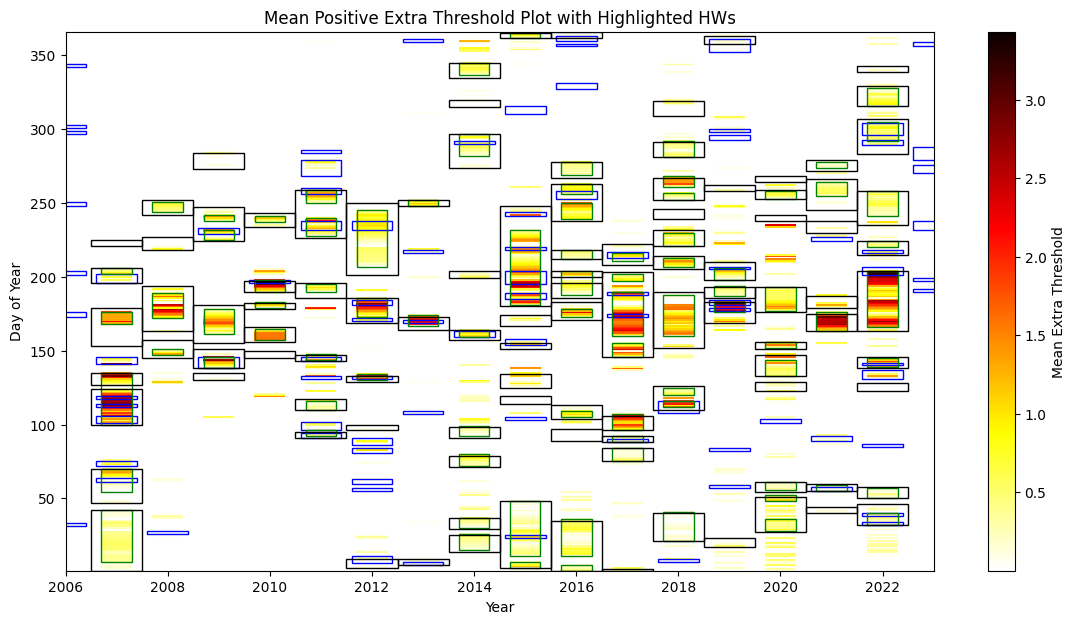

In [63]:
from matplotlib.patches import Rectangle
import calendar
# %matplotlib widget
# Filter the dataframe for intensity values between 0 and 5
filtered_df = df_mean_extrathresh[(df_mean_extrathresh['extrathresh'] >= 0) & (df_mean_extrathresh['extrathresh'] <= 5)]

# Create the plot 
fig, ax = plt.subplots(figsize=(14, 7))

# Create a scatter plot with day of year on the y-axis and year on the x-axis
sc = ax.scatter(filtered_df['time'].dt.year, filtered_df['time'].dt.dayofyear, 
                c=filtered_df['extrathresh'], cmap='hot_r',marker='_', s=500)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Mean Extra Threshold')


# Draw rectangles around the atmospheric events:
for index, row in air_hws_df.iterrows():
    start = row['begin_date']
    end = row['end_date']
    
    # Check if the event spans multiple years
    for year in range(start.year, end.year + 1):
        # Determine the start day for the year
        if start.year == year:
            start_day = start.timetuple().tm_yday
        else:
            start_day = 1
        
        # Determine the end day for the year
        if end.year == year:
            end_day = end.timetuple().tm_yday
        else:
            end_day = 366 if calendar.isleap(year) else 365
        
        # Draw the rectangle
        rect = Rectangle((year - 0.4, start_day), 0.8, end_day - start_day,
                         edgecolor='blue',alpha=1, facecolor='none', lw=1) 
        ax.add_patch(rect)
        
# Draw rectangles around the events calculated using mean value (1D)
for index, row in mean_hws_df.iterrows():
    start = row['date_start']
    end = row['date_end']
    
    # Check if the event spans multiple years
    for year in range(start.year, end.year + 1):
        # Determine the start day for the year
        if start.year == year:
            start_day = start.timetuple().tm_yday
        else:
            start_day = 1
        
        # Determine the end day for the year
        if end.year == year:
            end_day = end.timetuple().tm_yday
        else:
            end_day = 366 if calendar.isleap(year) else 365
        
        # Draw the rectangle
        rect = Rectangle((year - 0.3, start_day), 0.6, end_day - start_day,
                         edgecolor='green',alpha=1, facecolor='none', lw=1) 
        ax.add_patch(rect)

# Draw rectangles around the events
for index, row in filtered_heatwaves_df.iterrows():
    start = row['date_start']
    end = row['date_end']
    
    # Check if the event spans multiple years
    for year in range(start.year, end.year + 1):
        # Determine the start day for the year
        if start.year == year:
            start_day = start.timetuple().tm_yday
        else:
            start_day = 1
        
        # Determine the end day for the year
        if end.year == year:
            end_day = end.timetuple().tm_yday
        else:
            end_day = 366 if calendar.isleap(year) else 365
        
        # Draw the rectangle
        rect = Rectangle((year - 0.5, start_day), 1, end_day - start_day,
                         edgecolor='black',alpha=1, facecolor='none', lw=1) 
        ax.add_patch(rect)


# Set the y-axis to show days from 1 to 365/366
ax.set_ylim(1, 366)

# Set the x-axis to show the range of years
ax.set_xlim(filtered_df['time'].dt.year.min()-1, filtered_df['time'].dt.year.max()+1)

# Set axis labels
ax.set_xlabel('Year')
ax.set_ylabel('Day of Year')

# Set title
ax.set_title('Mean Positive Extra Threshold Plot with Highlighted HWs')
# # Save the plot
# save_path = '..\..\output\plot\DINEOF_Heatmap_New_Methodology_1d_3d_atm.png'
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
# Show the plot
plt.show()